In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [3]:
from scipy.signal import savgol_filter

In [4]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi = 1

In [5]:
mx = mx_list[15]
qq, drdq = [], []
for alpha in alpha_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq.append(drdq_npz['q_kev'])
    drdq.append(drdq_npz['drdq_hz_kev'])

alpha = alpha_list[19]
qq_1, drdq_1 = [], []
for mx in mx_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq_1.append(drdq_npz['q_kev'])
    drdq_1.append(drdq_npz['drdq_hz_kev'])


## Project the event rate onto the $z$-axis

In [82]:
i = 20
_qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1812468859.py:2: RuntimeWarning: divide by zero encountered in log
  _qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )


In [104]:
rand_seed = 22040403
rng = np.random.default_rng(rand_seed)

def get_random_q_samples(qq, drdq, rr):
    norm_factor = np.trapz(drdq, qq)

    f_drdq_norm = drdq / norm_factor       # PDF of q
    Fc_drdq_norm = np.cumsum(f_drdq_norm)  # CDF of q

    qq_sampled = np.interp(rr, Fc_drdq_norm, qq, left=0, right=0)
    return qq_sampled, norm_factor


In [105]:
n_mc = int(1e8)

rr = rng.uniform(0, 1, n_mc)
phiphi = rng.uniform(0, np.pi, n_mc)
noise_gaussian = rng.normal(0, 200, n_mc)

In [107]:
qq_sampled, norm = get_random_q_samples(_qq, _drdq_smoothed, rr)

hh, be   = np.histogram(qq_sampled, bins=np.arange(0, 5000, 50), density=True)
hhz, be  = np.histogram(qq_sampled*np.abs(np.cos(phiphi)), bins=np.arange(0, 5000, 50), density=True)
hhzn, be = np.histogram(qq_sampled*np.abs(np.cos(phiphi)) + noise_gaussian, bins=np.arange(0, 5000, 50), density=True)
bc = 0.5 * (be[1:] + be[:-1])

Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

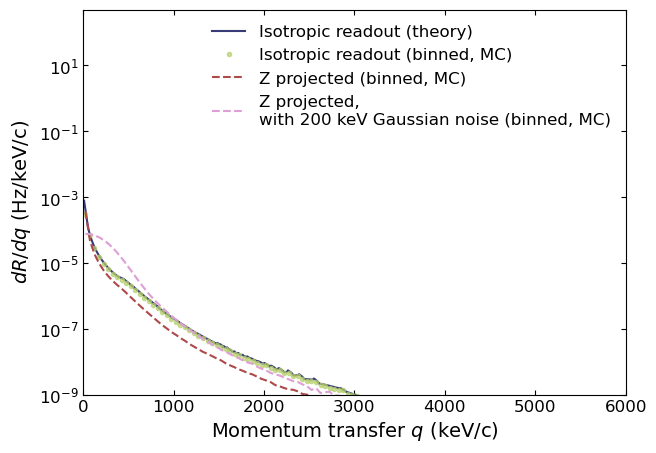

In [115]:
colors = plt.colormaps.get_cmap('tab20b').resampled(4).colors
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(_qq, _drdq_smoothed, '-', color=colors[0], label=f'Isotropic readout (theory)')
ax.plot(bc, hh*norm, '.', color=colors[1], alpha=0.7, label='Isotropic readout (binned, MC)')
ax.plot(bc, hhz*norm, '--', color=colors[2], label='Z projected (binned, MC)')
ax.plot(bc, hhzn*norm, '--', color=colors[3], label='Z projected, \nwith 200 keV Gaussian noise (binned, MC)')

ax.legend(frameon=False)

ax.set_ylim(1e-9, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')


Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

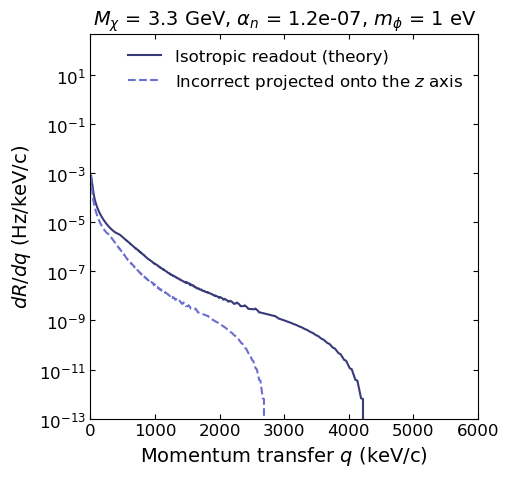

In [90]:
# Because <|cos theta|> = 2 / pi if theta is uniformly 
# distributed from 0 to pi
# This is incorrected! Because the tail should remain the same

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(_qq, _drdq_smoothed, '-' ,label=f'Isotropic readout (theory)')
ax.plot(_qq * 2 / np.pi, _drdq_smoothed, '--' ,label=f'Incorrect projected onto the $z$ axis')

ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
ax.legend(frameon=False)

ax.set_ylim(1e-13, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')

<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:14: SyntaxWarning: invalid escape sequence '\c'
  axes[1].plot(qq_1[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:27: SyntaxWarning: invalid escape sequence '\c'
  axes[0].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1630405506.py:27: SyntaxWarning: invalid escape sequence '\p'
  axes[0

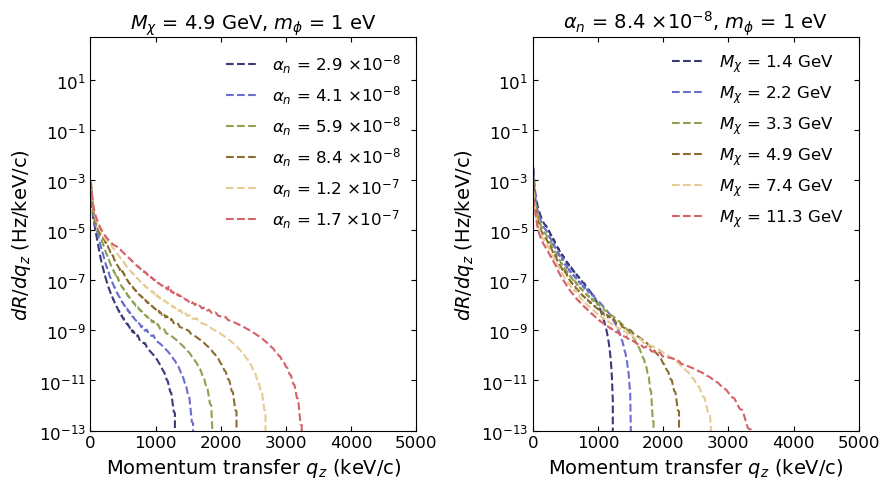

In [ ]:
# Plot the calculated event rate projected onto the z axis
# Smooth with a second order filter in the log space for plotting

fig, axes = plt.subplots(1, 2, figsize=(9, 5))

for i in range(16, 22):
    if alpha_list[i] > 1e-7:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-7:.1f} $\\times 10^{{-7}}$'
    else:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-8:.1f} $\\times 10^{{-8}}$'
    axes[0].plot(qq[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), '--' ,label=alpha_label)

for i in range(12, 18):
    axes[1].plot(qq_1[i]*2/np.pi, np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')

for ax in axes:
    ax.legend(frameon=False)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylim(1e-13, 500)
    ax.set_xlim(0, 5000)

    ax.set_xlabel('Momentum transfer $q_z$ (keV/c)')
    ax.set_ylabel('$dR / dq_z$ (Hz/keV/c)')

axes[0].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $m_\phi$ = 1 eV')
axes[1].set_title(f'$\\alpha_n$ = {alpha_list[19]/1e-8:.1f} $\\times 10^{{-8}}$, $m_\phi$ = 1 eV')

fig.tight_layout()

plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/dm_rate_drdqz.pdf', dpi=600)
